Study area bounds:
  North: 39.120322, South: 39.097413
  East: -84.512108, West: -84.540747
  Area: ~2.54 km × 2.47 km

This may take a minute...


/Users/sujankakumanu/miniconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sujankakumanu/miniconda3/envs/geospatial/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sujankakumanu/miniconda3/envs/geospatial/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


Network has 618 nodes and 1369 edges

Nodes columns: ['y', 'x', 'ref', 'highway', 'street_count', 'geometry']
Edges columns: ['osmid', 'oneway', 'lanes', 'highway', 'reversed', 'length', 'geometry', 'ref', 'name', 'maxspeed', 'bridge', 'access', 'area', 'tunnel', 'junction']

Total street length: 144.03 km

=== Basic Network Statistics ===
n: 618
m: 1369
k_avg: 4.4304
edge_length_total: 144030.3630
edge_length_avg: 105.2084
streets_per_node_avg: 3.1586
streets_per_node_counts: dict
streets_per_node_proportions: dict
intersection_count: 573
street_length_total: 103022.5250
street_segment_count: 945
street_length_avg: 109.0185
circuity_avg: 1.0197
self_loop_proportion: 0.0011

=== Calculating Centrality Metrics ===
Note: for MultiDiGraph we aggregate to a simple undirected graph for centrality calculations.
Calculating betweenness centrality (this can be slow for bigger graphs)...
Calculating closeness centrality...
Centrality calculations complete!

Number of dead ends: 4
Number of inte

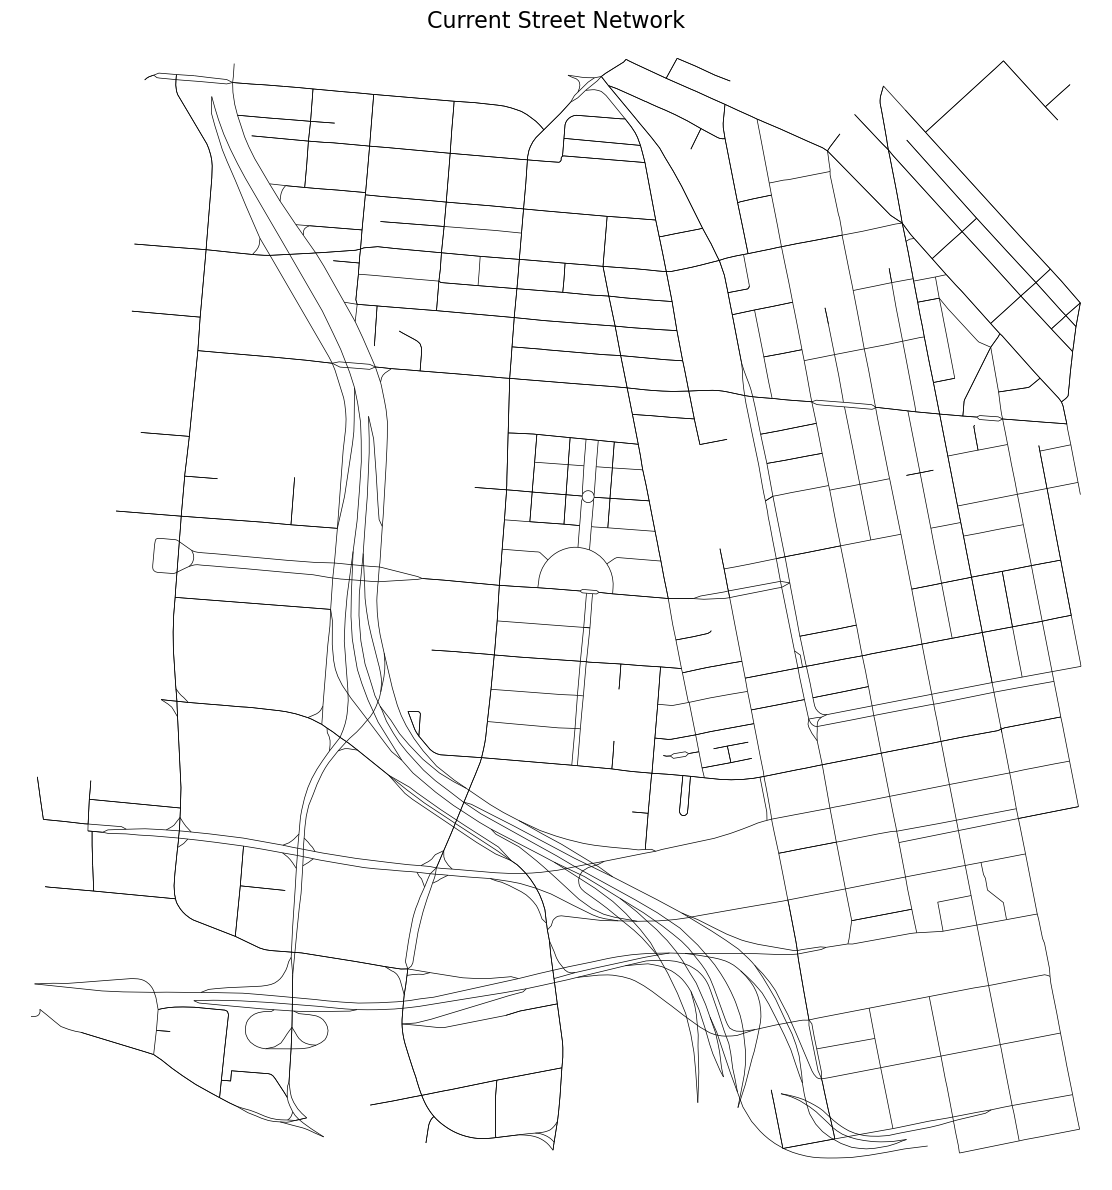

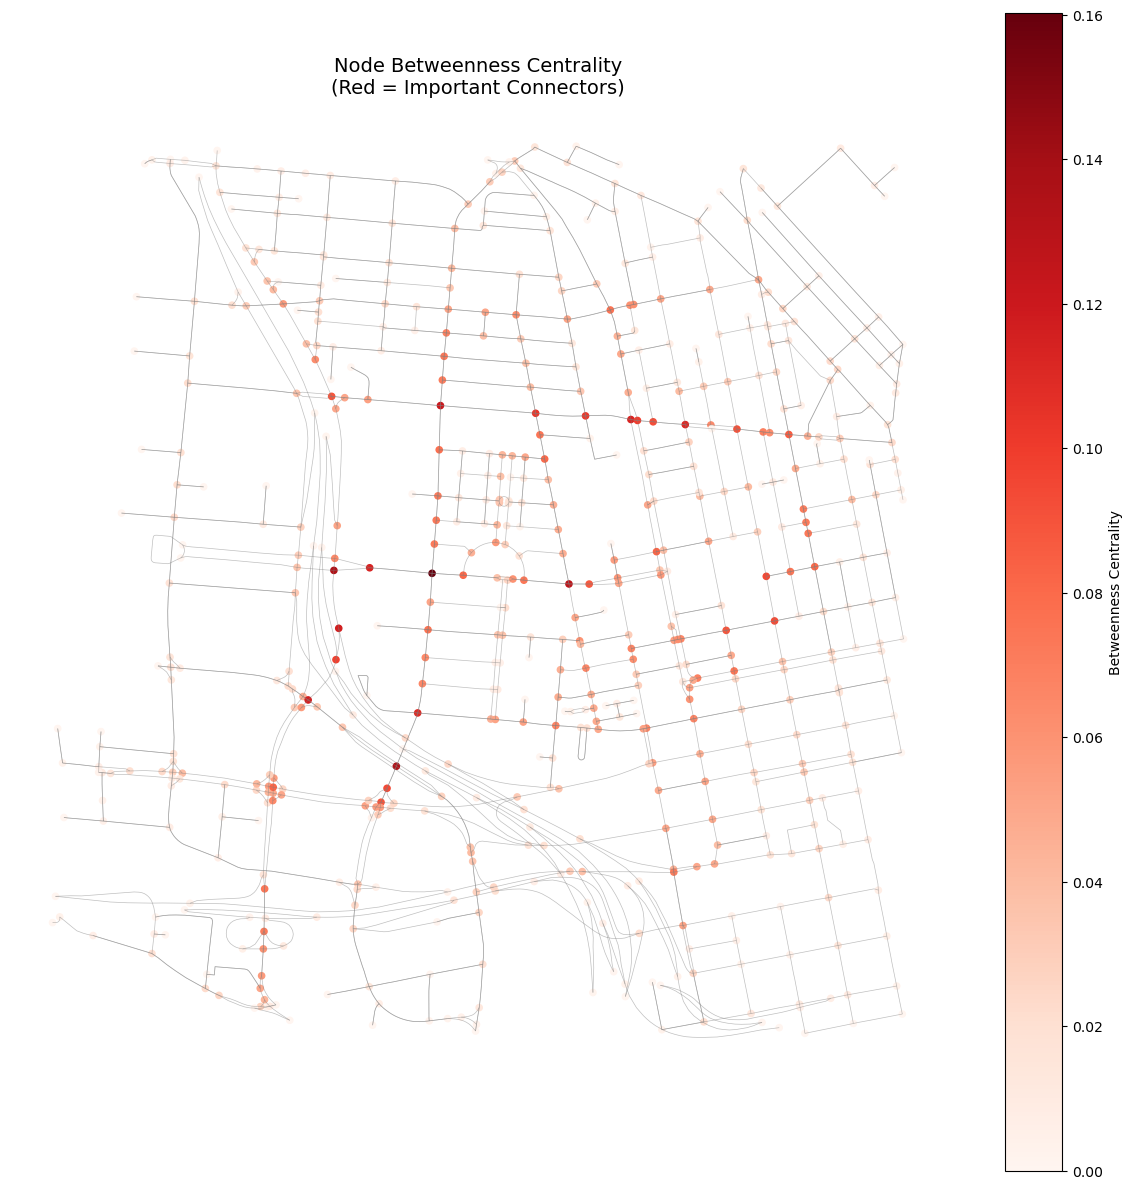

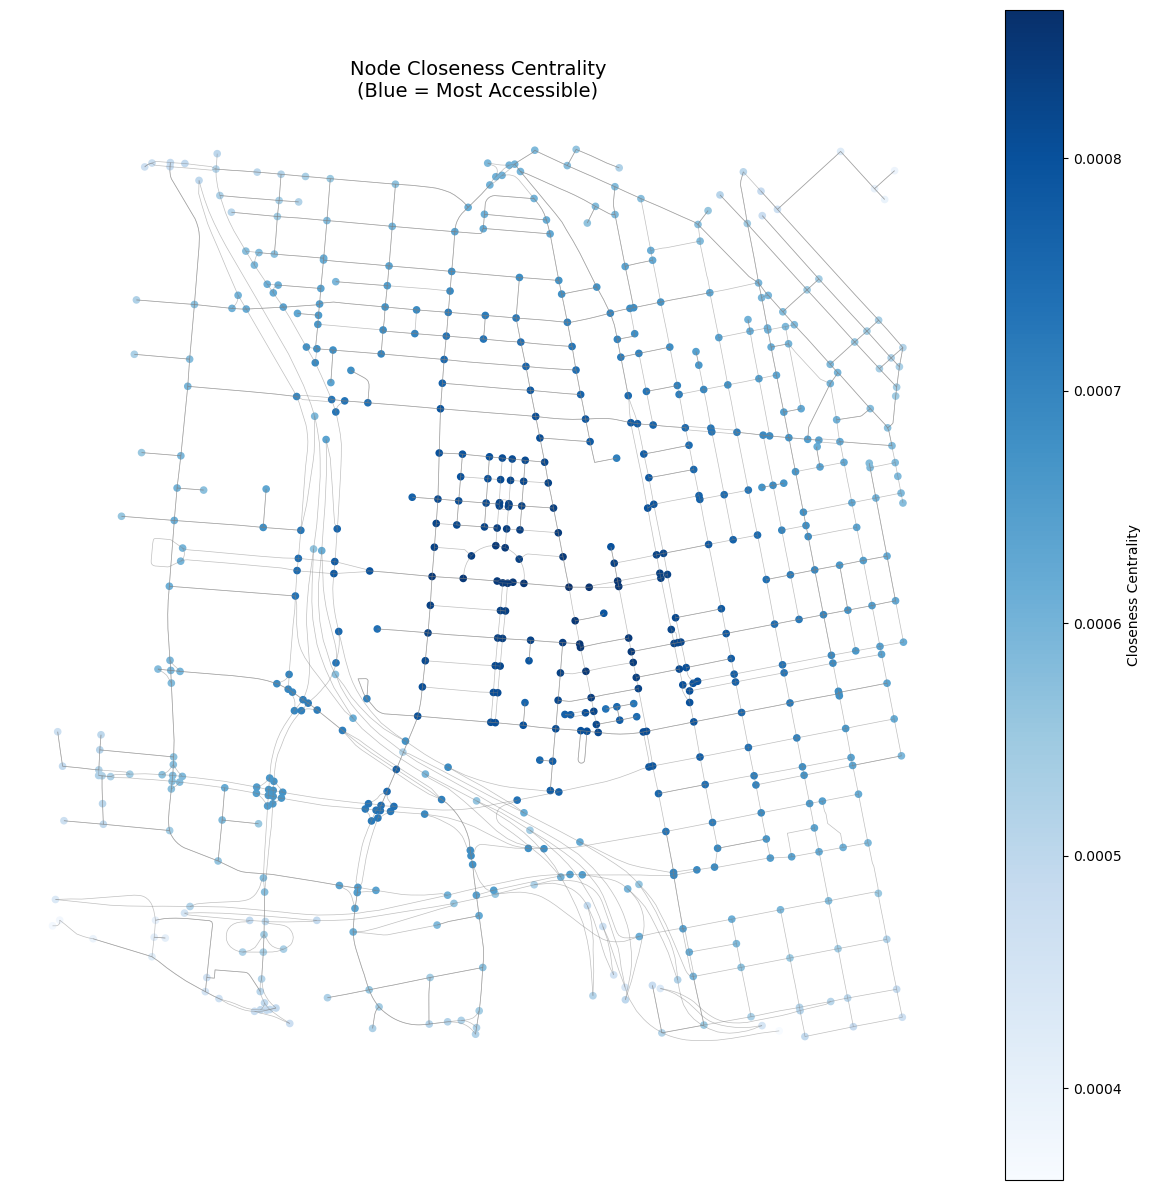


Cleaning geometries and attributes for export...
Geometry + attribute cleaning complete!

=== Files saved successfully ===
- current_network_nodes.geojson
- current_network_edges.geojson


In [13]:
# full_fixed_osmnx_script.py
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import numpy as np
import json

ox.settings.use_cache = True
ox.settings.log_console = False

# Using the aerial image
# SW: (39.097413, -84.540747), NE: (39.120322, -84.512108)
north = 39.120322
south = 39.097413
east = -84.512108
west = -84.540747

print("\nDownloading current street network from OpenStreetMap...")
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
print(f"Network has {len(G.nodes)} nodes and {len(G.edges)} edges")

nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# edges_gdf['length'] is in meters in OSMnx
if "length" in edges_gdf.columns:
    total_length_km = edges_gdf["length"].sum() / 1000.0
else:
    total_length_km = edges_gdf.geometry.length.sum() / 1000.0

print(f"\nTotal street length: {total_length_km:.2f} km")


def safe_buffer_zero(geom):
    try:
        if geom is None:
            return None
        fixed = geom.buffer(0)
        if fixed.is_empty:
            return geom
        return fixed
    except Exception:
        return geom


def flatten_value_for_geojson(v):
    if pd.isna(v):
        return None
    if isinstance(v, (list, tuple, set)):
        return ", ".join(map(lambda x: str(x) if x is not None else "", v))
    if isinstance(v, dict):
        try:
            return json.dumps(v, ensure_ascii=False)
        except Exception:
            return str(v)
    if isinstance(v, (np.integer, np.floating, np.bool_)):
        return v.item()
    return v

print("\n=== Basic Network Statistics ===")
try:
    stats = ox.basic_stats(G)
    for key, value in stats.items():
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")
        else:
            print(f"{key}: {type(value).__name__}")
except Exception as e:
    print("Warning: ox.basic_stats failed:", e)

print("\n=== Calculating Centrality Metrics ===")
print("Note: for MultiDiGraph we aggregate to a simple undirected graph for centrality calculations.")

# Create a simplified undirected Graph for centrality metrics.
# We aggregate parallel edges by taking the minimum 'length' (if present).
Gu = nx.Graph()
for u, v, data in G.edges(data=True):
    length = data.get("length", None)
    if length is None:
        # fallback to 1 if no length attribute; closeness/betweenness require positive distance
        length = 1.0
    # networkx Graph allows only one edge per (u, v) tuple; we keep smallest length
    if Gu.has_edge(u, v):
        # keep the smallest length
        if length < Gu[u][v].get("length", np.inf):
            Gu[u][v]["length"] = length
    else:
        Gu.add_edge(u, v, length=length)

# Betweenness centrality - on the undirected simplified graph
print("Calculating betweenness centrality (this can be slow for bigger graphs)...")
try:
    betweenness = nx.betweenness_centrality(Gu, weight="length", normalized=True)
except Exception as e:
    print("Betweenness centrality failed or is too slow; falling back to unweighted version. Error:", e)
    betweenness = nx.betweenness_centrality(Gu, normalized=True)

# Closeness centrality - uses 'length' as distance
print("Calculating closeness centrality...")
try:
    closeness = nx.closeness_centrality(Gu, distance="length")
except Exception as e:
    print("Closeness centrality fell back to unweighted version. Error:", e)
    closeness = nx.closeness_centrality(Gu)

# Degree centrality - use original directed graph's degree (or undirected version)
degree_centrality = nx.degree_centrality(Gu)

# Map centrality values back to nodes_gdf (index is node id)
nodes_gdf = nodes_gdf.copy()
nodes_gdf["betweenness"] = nodes_gdf.index.map(lambda nid: betweenness.get(nid, 0.0))
nodes_gdf["closeness"] = nodes_gdf.index.map(lambda nid: closeness.get(nid, 0.0))
nodes_gdf["degree_centrality"] = nodes_gdf.index.map(lambda nid: degree_centrality.get(nid, 0.0))

print("Centrality calculations complete!")

# ============================================================================
# 5. ANALYZE STREET CONNECTIVITY
# ============================================================================

dead_ends = [node for node, degree in G.degree() if degree == 1]
print(f"\nNumber of dead ends: {len(dead_ends)}")

intersections = [node for node, degree in G.degree() if degree >= 3]
print(f"Number of intersections: {len(intersections)}")

avg_degree = sum(dict(G.degree()).values()) / max(1, len(G.nodes()))
print(f"Average node degree: {avg_degree:.2f}")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================

# Plot 1: Basic network (ox.plot_graph returns matplotlib figure, ax)
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.5,
    bgcolor="white",
    edge_color="black",
    figsize=(12, 12),
    show=False,
    close=False,
)
plt.title("Current Street Network", fontsize=16)
plt.tight_layout()
plt.show()

# Plot 2: Betweenness centrality (nodes)
fig, ax = plt.subplots(figsize=(12, 12))
nodes_gdf.plot(
    column="betweenness",
    ax=ax,
    cmap="Reds",
    markersize=20,
    legend=True,
    legend_kwds={"label": "Betweenness Centrality"},
)
edges_gdf.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.5)
plt.title("Node Betweenness Centrality\n(Red = Important Connectors)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# Plot 3: Closeness centrality (nodes)
fig, ax = plt.subplots(figsize=(12, 12))
nodes_gdf.plot(
    column="closeness",
    ax=ax,
    cmap="Blues",
    markersize=20,
    legend=True,
    legend_kwds={"label": "Closeness Centrality"},
)
edges_gdf.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.5)
plt.title("Node Closeness Centrality\n(Blue = Most Accessible)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# ============================================================================
# 7. CLEAN GEOMETRIES + FLATTEN ATTRIBUTES BEFORE EXPORT
# ============================================================================

print("\nCleaning geometries and attributes for export...")

# 1) Remove NaN geometries
edges_gdf = edges_gdf[edges_gdf.geometry.notna()].copy()
nodes_gdf = nodes_gdf[nodes_gdf.geometry.notna()].copy()

# 2) Attempt to fix invalid geometries using buffer(0)
edges_gdf["geometry"] = edges_gdf["geometry"].apply(safe_buffer_zero)
nodes_gdf["geometry"] = nodes_gdf["geometry"].apply(safe_buffer_zero)

# Optionally drop any empty geometries that couldn't be fixed
edges_gdf = edges_gdf[~edges_gdf.geometry.is_empty].copy()
nodes_gdf = nodes_gdf[~nodes_gdf.geometry.is_empty].copy()

# 3) Flatten list/dict-like columns to strings (GeoJSON can't store Python lists)
for gdf in (nodes_gdf, edges_gdf):
    for col in gdf.columns:
        if col == "geometry":
            continue
        # apply flattening with a safe conversion
        try:
            gdf[col] = gdf[col].apply(flatten_value_for_geojson)
        except Exception:
            # fallback: convert whole column to string
            gdf[col] = gdf[col].astype(str).where(~gdf[col].isna(), None)

print("Geometry + attribute cleaning complete!")

# ============================================================================
# 8. EXPORT FOR FURTHER ANALYSIS
# ============================================================================

# Save to GeoJSON files
# If you prefer shapefile, note shapefile has stricter type limits and field name length limits.
nodes_gdf.to_file("current_network_nodes.geojson", driver="GeoJSON")
edges_gdf.to_file("current_network_edges.geojson", driver="GeoJSON")

print("\n=== Files saved successfully ===")
print("- current_network_nodes.geojson")
print("- current_network_edges.geojson")


=== Comparing with Historical Network ===
Current street network: 144225 meters
Historical streets: 24272 meters
Historical network was 16.8% longer


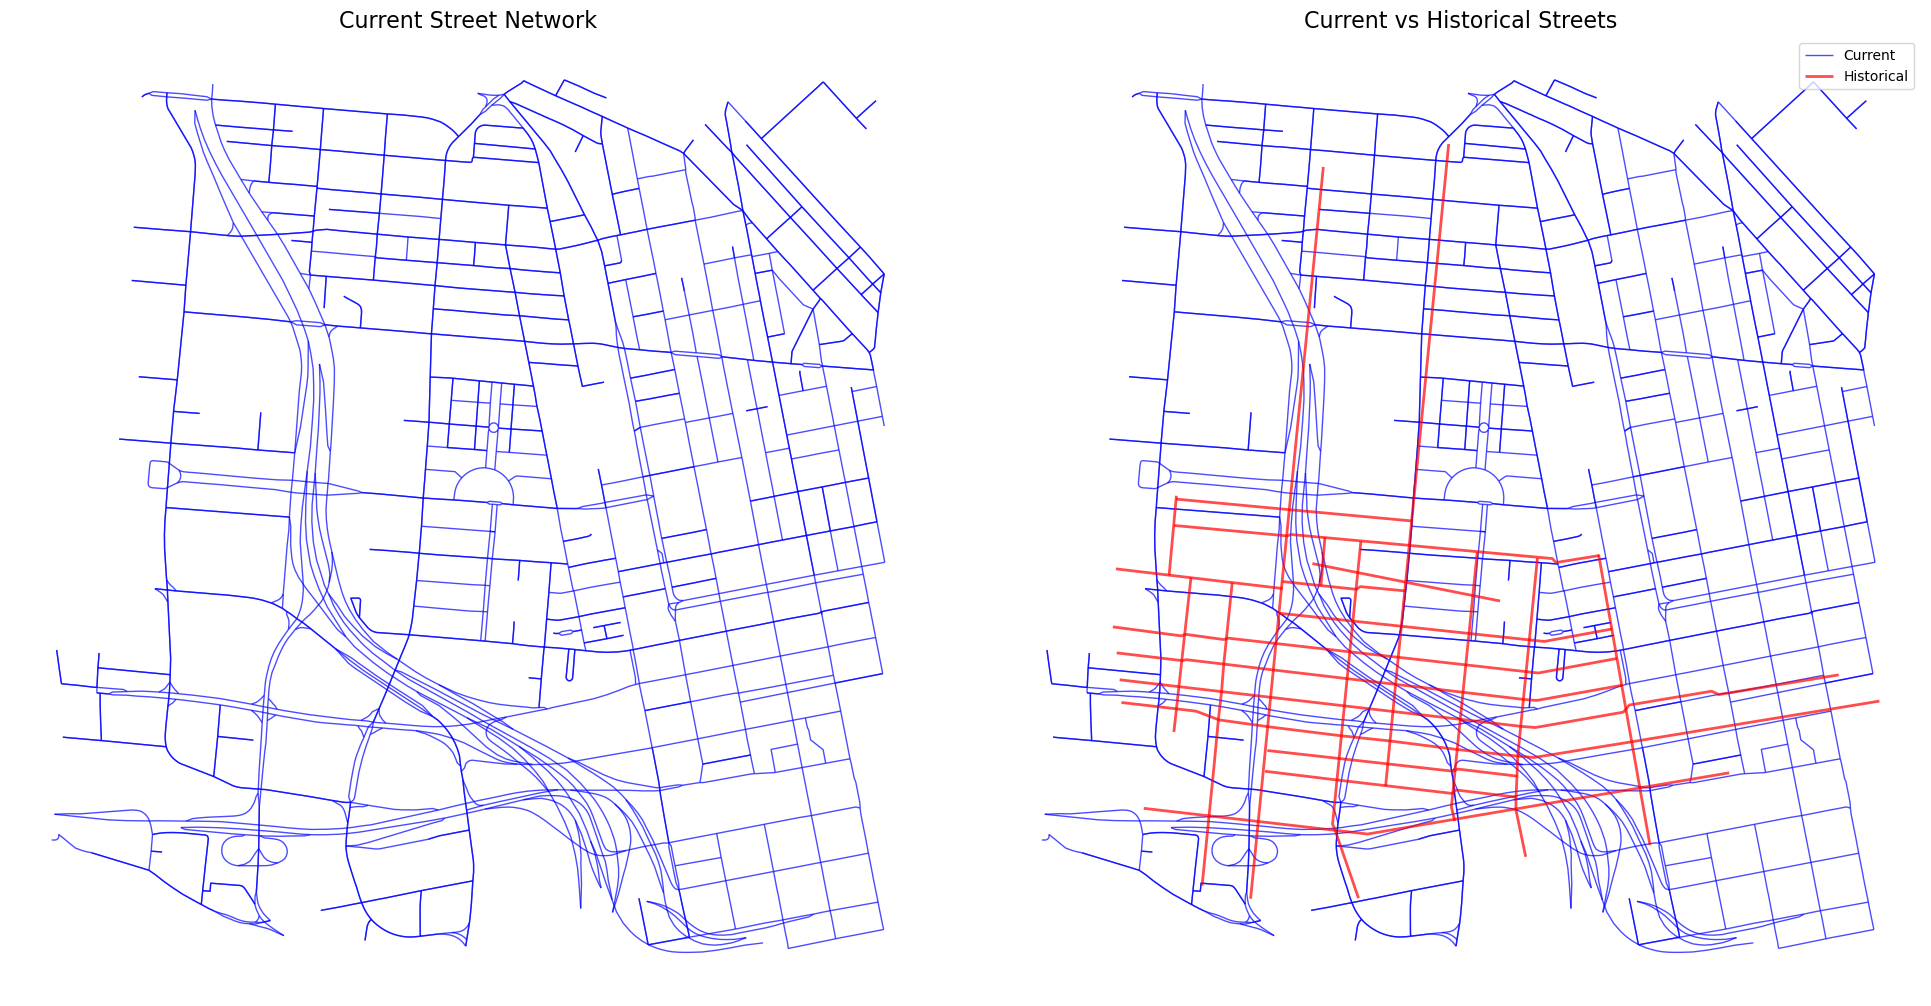

In [16]:
# ============================================================================
# 9. (OPTIONAL) COMPARE WITH MISSING STREETS - Uncomment and edit path
# ============================================================================

print("\n=== Comparing with Historical Network ===")
missing_streets = gpd.read_file("../data/streets/cincinnati_kenyon_barr_streets.geojson")

if missing_streets.crs != edges_gdf.crs:
    missing_streets = missing_streets.to_crs(edges_gdf.crs)

# Project to UTM zone 17N (meters)
edges_m = edges_gdf.to_crs(26917)
missing_m = missing_streets.to_crs(26917)

missing_length = missing_m.geometry.length.sum()
current_length = edges_m.geometry.length.sum()

print(f"Current street network: {current_length:.0f} meters")
print(f"Historical streets: {missing_length:.0f} meters")
print(f"Historical network was {(missing_length/current_length)*100:.1f}% longer")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
edges_gdf.plot(ax=ax1, color='blue', linewidth=1, alpha=0.7)
ax1.set_title('Current Street Network', fontsize=16)
ax1.axis('off')

edges_gdf.plot(ax=ax2, color='blue', linewidth=1, alpha=0.7, label='Current')
missing_streets.plot(ax=ax2, color='red', linewidth=2, alpha=0.7, label='Historical')
ax2.set_title('Current vs Historical Streets', fontsize=16)
ax2.legend()
ax2.axis('off')

plt.tight_layout()
plt.show()